## Importa módulos

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cx_Oracle
import pandas as pd
import numpy as np
import logging
import json
import itertools
import _pickle as cPickle
from IPython.core.debugger import Tracer
from functools import reduce
import operator
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from multiprocessing import Pool
import os
from sklearn.metrics import confusion_matrix
from classificadores import regex
import dask.dataframe as ddf
from dask.delayed import delayed
from multiprocessing import cpu_count

## Variáveis de configuração

In [2]:
DS_EXADATA_HOST=os.environ['DB_HOST']
DS_EXADATA_PORT=os.environ['DB_PORT']
DS_EXADATA_SID=os.environ['DB_SID']
DS_EXADATA_user=os.environ['DB_USER']
DS_EXADATA_password=os.environ['DB_PASSWORD']

pd.set_option('display.max_colwidth', 300)
CACHE=True

## Conexão com banco

In [3]:
dsn_tns = cx_Oracle.makedsn(
        DS_EXADATA_HOST,
        DS_EXADATA_PORT,
        DS_EXADATA_SID)
ora_conn = cx_Oracle.connect(
        DS_EXADATA_user,
        DS_EXADATA_password,
        dsn_tns,
        encoding="UTF-8",
        nencoding="UTF-8",
        threaded=True)

## Query dos processos

#### Extrai os valores do cx_Oracle.LOB, processo lento e pouco paralelizável
#### Altere a variável CACHE para utilizar um pickle armazenado anteriormente

In [4]:
if CACHE:
    %time df_ora = pd.read_pickle('df_ora_lido.pkl')
else:
    df_ora = pd.read_sql("""SELECT TJRJ_PROCESSO_MOVIMENTO_TJ.*, 0 as EH_SENTENCA 
     FROM tjrj.TJRJ_PROCESSO_MOVIMENTO_TJ 
     WHERE PRMV_TX_INTEIRO_TEOR IS NOT NULL
     and PRMV_TP_MOVIMENTO is not null""", con=ora_conn)

    %time df_ora['PRMV_TX_INTEIRO_TEOR'] = df_ora.PRMV_TX_INTEIRO_TEOR.apply(lambda x: x.read())
    
    df_ora.loc[df_ora.PRMV_TP_MOVIMENTO.str.contains('sentença', case=False), 'EH_SENTENCA'] = 1
    df_ora['resultado_classificacao'] = 0
    
    df_ora.to_pickle('df_ora_lido.pkl')

CPU times: user 261 ms, sys: 101 ms, total: 362 ms
Wall time: 361 ms


# Classificação dos documentos

### 1 Define Matriz de confusão

In [6]:
from collections import namedtuple

MatrizConfusao = namedtuple('MatrizConfusao', ['acuracia', 'sensibilidade', 'especificidade'])

def matrix_de_confusao(corretos, classificados):
    n = len(corretos)
    classificados_corretamentes = sum(corretos == classificados)
    acuracia = classificados_corretamentes / n * 100
    
    sensibilidade = (sum(np.logical_and(classificados == 1, corretos == 1)) 
                     / sum(corretos == 1)) * 100
    especificidade = (sum(np.logical_and(classificados == 0, corretos == 0)) 
                     / sum(corretos == 0)) * 100
    
    
    return MatrizConfusao(acuracia, sensibilidade, especificidade)


def _verifica_resultado(resultado):
    return resultado['positivo']

#### Aplica classificadores em paralelo

In [8]:
def classifica(item):
    return _verifica_resultado(regex.classifica_item(item))
        

def tempo():
    with Pool(cpu_count()) as pool:
        resultado = pool.map(
            classifica,
            df_ora.PRMV_TX_INTEIRO_TEOR.values)
        df_ora['resultado_classificacao'] = resultado
    
%time tempo()

CPU times: user 357 ms, sys: 274 ms, total: 631 ms
Wall time: 27 s


In [9]:
def plota_matriz_confusao(cm, axis, normalizado):
    fmt = '.2f' if normalizado else 'd'
    axis.imshow(cm, cmap=plt.cm.Blues)
    axis.set(ylabel = 'Observado')
    axis.set(xlabel = 'Predito')
    thresh = cm.max() / 2.
    axis.set_xticklabels("")
    axis.set_yticklabels("")
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        axis.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

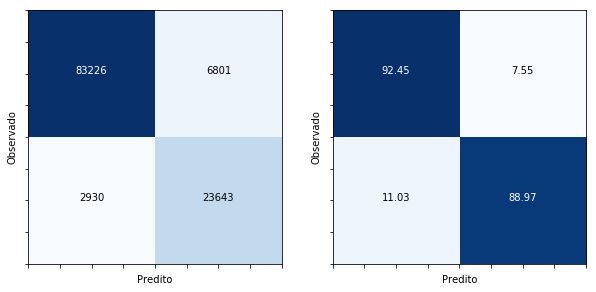

In [10]:
cm = confusion_matrix(df_ora.EH_SENTENCA.values, df_ora.resultado_classificacao.values, labels=[0, 1])
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
fig, (ax1, ax2) = plt.subplots(1, 2)
plota_matriz_confusao(cm, ax1, False)
plota_matriz_confusao(cmn, ax2, True)
fig.set_size_inches(10,8)

Ideias:

1. Aplicar auto corretor no texto para um catálogo de palávras pré-definido, ie.:
    PROCENTE -> PROCEDENTE
2. Tentar excluir parágrafos iniciais da análise, ie.: primeiros 30%
3. Criar um dicionário de palavras soletradas e remover os espaços em branco das sentenças


### Log de Rultados

#### 20/04/2018
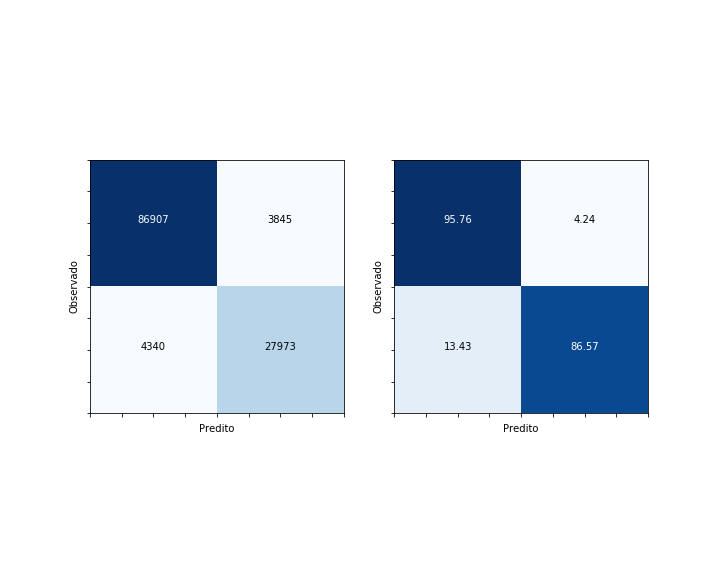


#### 24/04/2018
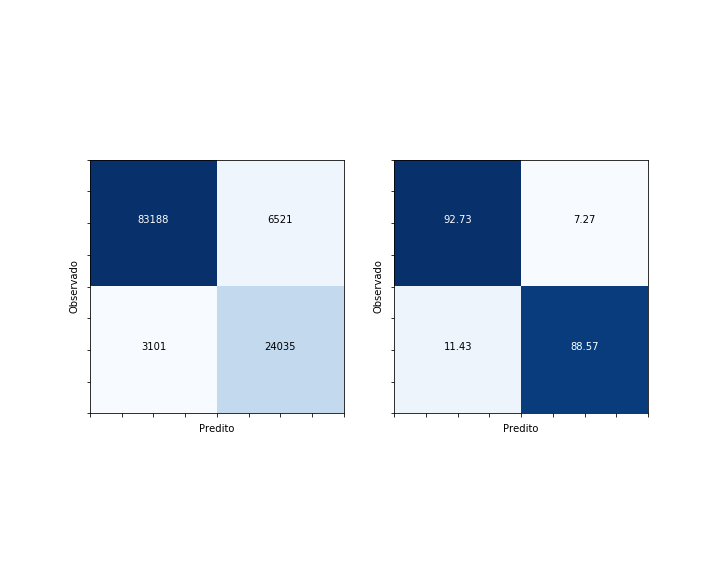

#### 26/04/2018
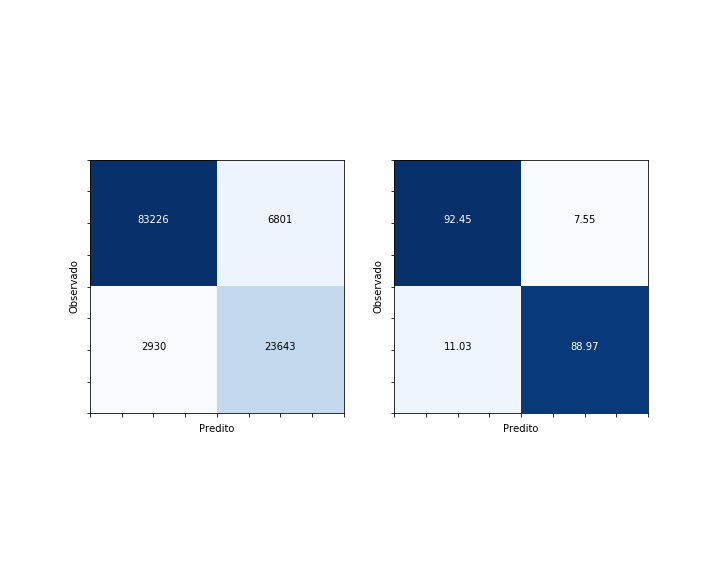


In [11]:
CHECKPOINT = False
if CHECKPOINT:
        fig.savefig('df_ora-03.png')
        df_ora.to_pickle('df_ora-03.pkl')